In [1]:
%load_ext autoreload
%autoreload 2

import sys,glob,os,errno
import numpy as np
import matplotlib.pyplot as plt

### Custom code
helpers = os.path.abspath('../../../Helpers')
if helpers not in sys.path:
    sys.path.append(helpers)
from dustextinction import (
    get_gal_extinction_from_radec,
    get_xredden_template_model,
)
from utils import (
    get_dataset_energy_edges,
    get_dataset_energy_edges_from_aeff_integral
)

from gammapy.datasets import Datasets
from gammapy.estimators import FluxPointsEstimator
from gammapy.modeling import Fit
from gammapy.modeling.models import Models

## Datasets and models

In [2]:
basedir = os.path.abspath("../../../")
datasetdir  = f"{basedir}/UVOT/MJD60373/"

# load the dataset and models (without hydrogen-absorption), assuming we start from the Notebooks directory
uvot_datasets = Datasets.read(f"{datasetdir}/dataset.yaml")
uvot_datasets.models = list(Models.read(f"{datasetdir}/models.yaml"))
extinction_model = get_xredden_template_model(f"{basedir}/Models/xredden_tau_factor_vs_EBV_energy.ecsv",
                                              srcname='OP313')

extinction_model.parameters['ebv'].frozen = True
uvot_datasets.models[0].spectral_model *= extinction_model

/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/gammapy/utils/scripts.py:66: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)


## Fit and flux points

In [3]:
# Define a fit
uvot_only_fit    = Fit(store_trace=True)
uvot_only_result = uvot_only_fit.run(uvot_datasets)
# we make a copy here for later comparisons
uvot_only_model = uvot_datasets.models.copy()
# spectral points
energy_edge_pairs = [get_dataset_energy_edges(d) for d in uvot_datasets]
uvot_only_fpe     = [FluxPointsEstimator(energy_edges=edges, source="OP313") for edges in energy_edge_pairs]
uvot_only_points  = [uvot_only_fpe[k].run(datasets=d) for k,d in enumerate(uvot_datasets)]

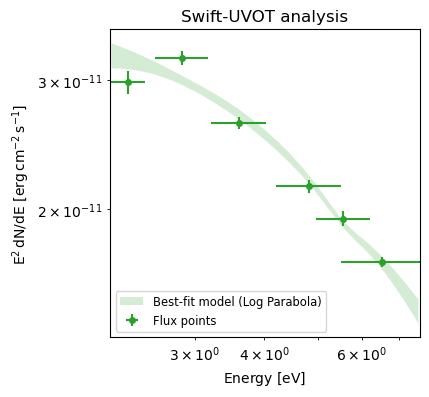

In [4]:
plt.figure(figsize=(4, 4),dpi=100)

emin = min([min(pair) for pair in energy_edge_pairs])
emax = max([max(pair) for pair in energy_edge_pairs])

ax = uvot_only_model['OP313'].spectral_model.plot_error(
    [emin.to('eV'),emax.to('eV')],
    facecolor='C2',label='Best-fit model (Log Parabola)',
    sed_type='e2dnde')

for k,point in enumerate(uvot_only_points):
    point.plot(
        ax=ax, color="C2", sed_type='e2dnde',
        label='Flux points' if k==0 else '',
    )

ax.set_xlim(emin,emax)
ax.set_title('Swift-UVOT analysis')
ax.set_ylabel('$\mathrm{E^2\,dN/dE}$ $\mathrm{[erg\,cm^{-2}\,s^{-1}]}$')
ax.legend(loc=3,fontsize='small',)

!mkdir -p {basedir}/Figures/MJD60373/Swift-UVOT/
plt.savefig(f'{basedir}/Figures/MJD60373/Swift-UVOT/BestFit-Swift-UVOT.pdf',bbox_inches='tight')